In [78]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import tensorflow as tf

import utils

np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Regression

In [3]:
# Load data
data = np.loadtxt('./data/data_w3_ex1.csv', delimiter=',')

# Split the inputs and outputs
x = data[:,0]
y = data[:,1]

# Convert to 2d array
x = np.expand_dims(x, axis=1)
y  = np.expand_dims(y, axis=1)

x.shape, y.shape

((50, 1), (50, 1))

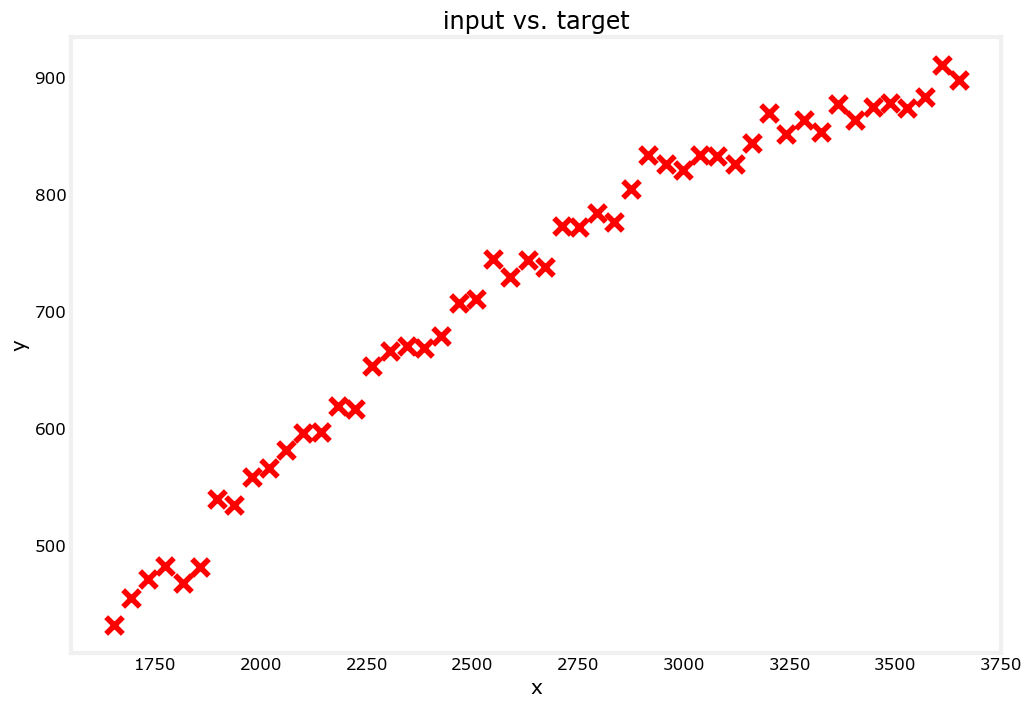

In [6]:
# Plot the entire dataset
utils.plot_dataset(x=x, y=y, title="input vs. target")

In [7]:
# Train vs test
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=30)
# Cross validation
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.5, random_state=30)

# Delete temp variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


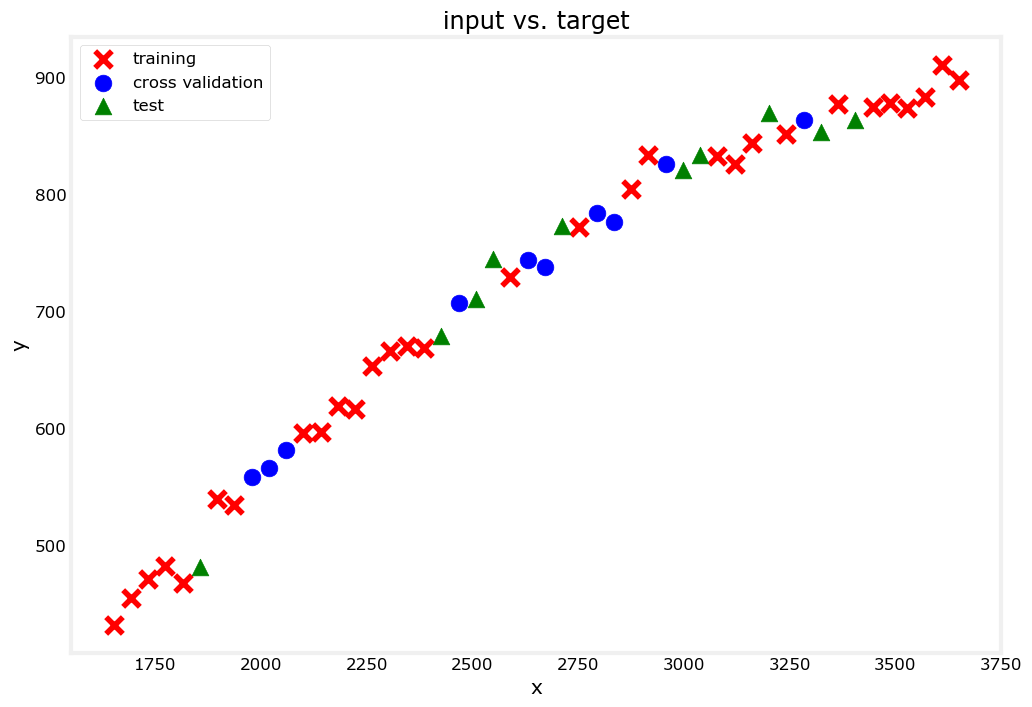

In [8]:
utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title='input vs target')

You will only use $x$ for this first model but it's good to practice feature scaling now so you can apply it later. For that, you will use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from scikit-learn. This computes the z-score of your inputs. As a refresher, the z-score is given by the equation:

$$ z = \frac{x - \mu}{\sigma} $$

Computed mean of the training set: 2627.87
Computed standard deviation of the training set: 664.02


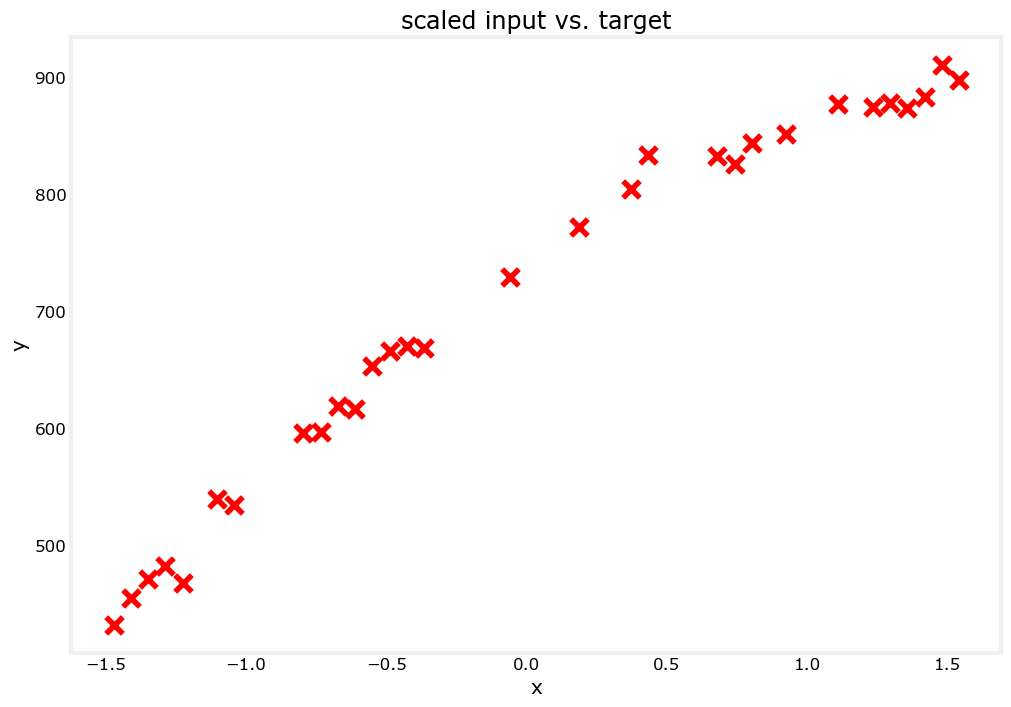

In [9]:
# Initialize class
scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler.scale_.squeeze():.2f}")

# Plot the results
utils.plot_dataset(x=x_train_sc, y=y_train, title="scaled input vs. target")

In [10]:
# Train model
linear_model = LinearRegression()
linear_model.fit(x_train_sc, y_train)

LinearRegression()

In [18]:
yhat = linear_model.predict(x_train_sc)

print(f"Training MSE (sklearn): {mean_squared_error(y_train, yhat)/2}")

# for loop imp
total_squared_error = 0

for i in range(len(yhat)):
    squared_error_i  = (yhat[i] - y_train[i])**2
    total_squared_error += squared_error_i                                              

mse = total_squared_error / (2*len(yhat))

print(f"training MSE (for-loop implementation): {mse.squeeze()}")

Training MSE (sklearn): 450.3340993773597
training MSE (for-loop implementation): 450.33409937735956


In [19]:
x_cv_sc = scaler.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler.mean_.squeeze():.2f}")
print(f"Standard deviation used to scale the CV set: {scaler.scale_.squeeze():.2f}")

# Feed the scaled cross validation set
yhat = linear_model.predict(x_cv_sc)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Mean used to scale the CV set: 2627.87
Standard deviation used to scale the CV set: 664.02
Cross validation MSE: 387.12423882985996


In [20]:
# Adding features
poly = PolynomialFeatures(degree=2, include_bias=False)

x_train_mapped = poly.fit_transform(x_train)

print(x_train_mapped[:5])

[[2.92e+03 8.50e+06]
 [3.37e+03 1.13e+07]
 [3.24e+03 1.05e+07]
 [3.12e+03 9.74e+06]
 [2.88e+03 8.27e+06]]


In [23]:
# Scale to narrow range of values
scaler_poly = StandardScaler()
x_train_mapped_scaled = scaler_poly.fit_transform(x_train_mapped)
print(x_train_mapped_scaled[:5])

[[0.43 0.33]
 [1.11 1.12]
 [0.93 0.89]
 [0.74 0.67]
 [0.37 0.26]]


In [39]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(x_train_mapped_scaled, y_train )

# Compute the training MSE
yhat = model.predict(x_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
x_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
x_cv_mapped_scaled = scaler_poly.transform(x_cv_mapped)

# Compute the cross validation MSE
yhat = model.predict(x_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")
x_cv_mapped_scaled.shape

Training MSE: 450.3340993773597
Cross validation MSE: 387.12423882985996


(10, 1)

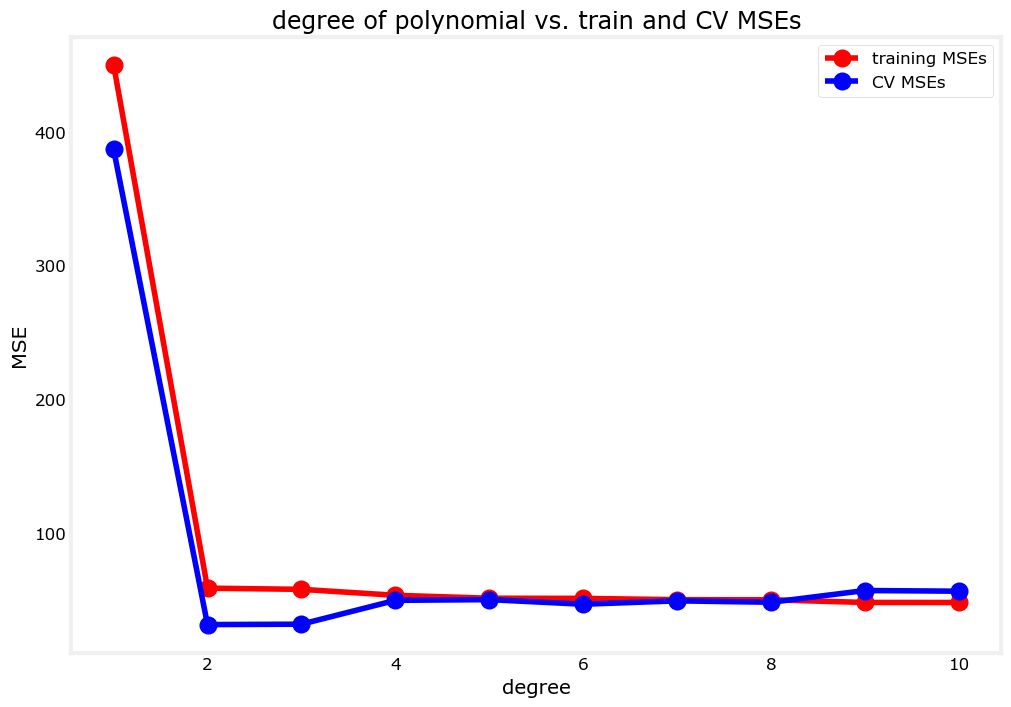

In [40]:
train_mses = []
cv_mses = []
models = []
polys = []
scalers = []

# Check 10 polys 
for degree in range(1,11):
    # Polynomial features
    poly = PolynomialFeatures(degree, include_bias=False)
    x_train_mapped = poly.fit_transform(x_train)
    polys.append(poly)
    
    # Scaler
    scaler_poly = StandardScaler()
    x_train_mapped_scaled = scaler_poly.fit_transform(x_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LinearRegression()
    model.fit(x_train_mapped_scaled, y_train)
    models.append(model)
    
    # MSE
    yhat = model.predict(x_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Cross validation
    x_cv_mapped = poly.transform(x_cv)
    x_cv_mapped_scaled = scaler_poly.transform(x_cv_mapped)
    yhat = model.predict(x_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)

# Plot the results
degrees=range(1,11)
utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")                                         

In [41]:
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

Lowest CV MSE is found in the model with degree=2


In [45]:
# Test
x_test_mapped = polys[degree-1].transform(x_test)
x_test_mapped_scaled = scalers[degree-1].transform(x_test_mapped)
yhat = models[degree-1].predict(x_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 58.76
Cross Validation MSE: 31.52
Test MSE: 111.76


# Neural Networks

In [46]:
# Add polynomial features
degree = 1
poly = PolynomialFeatures(degree, include_bias=False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

In [47]:
# Scale the features using the z-score
scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

In [49]:
# Build and train models
nn_train_mses = []
nn_cv_mses = []

# build models
nn_models = utils.build_models()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    )

    print(f"Training {model.name}...")
    
    # Train the model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs=300,
        verbose=0
    )
    print("Done!\n")
    
    # Record the training MSEs
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)
    
    # Record the cross validation MSEs 
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

# print results
print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}"
        )

Training model_1...
Done!

1/1 [==============================] - 0s 32ms/step
Training model_2...
Done!

1/1 [==============================] - 0s 24ms/step
Training model_3...
Done!

1/1 [==============================] - 0s 33ms/step
RESULTS:
Model 1: Training MSE: 64.99, CV MSE: 108.07
Model 2: Training MSE: 450.33, CV MSE: 387.13
Model 3: Training MSE: 60.86, CV MSE: 120.48


In [50]:
model_num = 1

# Select the model with the lowest CV MSE
model_num = 3

# Compute the test MSE
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 [==============================] - 0s 39ms/step
Selected Model: 3
Training MSE: 60.86
Cross Validation MSE: 120.48
Test MSE: 97.74


# Classification

In [51]:
# Load the dataset from a text file
data = np.loadtxt('./data/data_w3_ex2.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


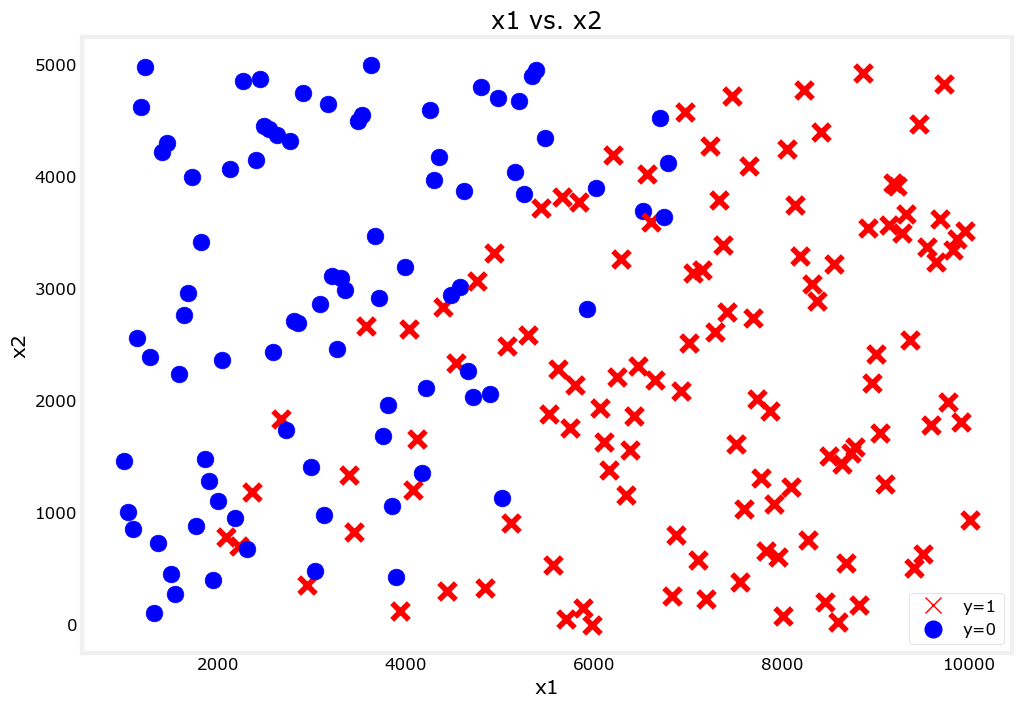

In [52]:
utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

In [53]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


In [54]:
# Scale the features

# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

In [55]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


In [64]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []
accuracy_train = []
accuracy_cv = []
# Build the models
models_bc = utils.build_models()

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train_scaled, y_bc_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")
    
    # Set the threshold for classification
    threshold = 0.5
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)
    
    acc = accuracy_score(y_bc_train, yhat)
    accuracy_train.append(acc)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)
    
    acc = accuracy_score(y_bc_cv, yhat)
    accuracy_cv.append(acc)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}, Train set accuracy: {accuracy_train[model_num]:.2f}%, " +
        f"CV Set accuracy: {accuracy_cv[model_num]:3f}%"
        )

Training model_1...
Done!

2/2 [==============================] - 0s 3ms/step
Training model_2...
Done!

2/2 [==============================] - 0s 0s/step
Training model_3...
Done!

2/2 [==============================] - 0s 16ms/step
Model 1: Training Set Classification Error: 0.07500, CV Set Classification Error: 0.17500, Train set accuracy: 0.93%, CV Set accuracy: 0.825000%
Model 2: Training Set Classification Error: 0.07500, CV Set Classification Error: 0.17500, Train set accuracy: 0.93%, CV Set accuracy: 0.825000%
Model 3: Training Set Classification Error: 0.10833, CV Set Classification Error: 0.17500, Train set accuracy: 0.89%, CV Set accuracy: 0.825000%


In [77]:
# Select the model with the lowest error
model_num = 2

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

print(f"Test Set Overall Accuracy: {accuracy_score(y_bc_test, yhat)}")

2/2 [==============================] - 0s 525us/step
Selected Model: 2
Training Set Classification Error: 0.0750
CV Set Classification Error: 0.1750
Test Set Classification Error: 0.1750
Test Set Overall Accuracy: 0.825
